In [70]:
%matplotlib inline
%run /Users/marisa/git/practice/Sampler.py
import math
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import random

random.seed(123)
np.random.seed(123) #scipy uses this one.

In [55]:
# Load NOAA Precip data and deal with flags in numeric column
df2 = getAndCleanPrecip()
df2.shape

(3285, 2)

min=0.0, max=5.2


<function print>

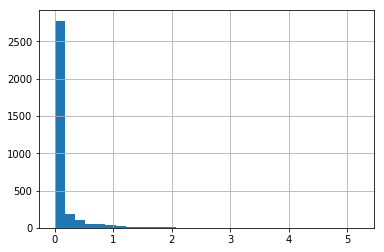

In [56]:
df2['precipNum'].hist(bins=30)
print(f"min={df2['precipNum'].min()}, max={df2['precipNum'].max()}")
print

In [57]:
####### HELPER CLASSES ########
# gamma prior on lambda
class LambdaPrior:
    def __init__(self, alpha, beta):
        self.fn = stats.gamma(alpha, loc = 0, scale = 1)
        self.alpha = alpha
        self.beta = beta
        self.proposeDistr = stats.norm # initialize
        
    # Generate candidate lambda using proposal distribution around last good lambda
    def sample(self, lastLambda, proposeStdDev):
        return lastLambda + self.proposeDistr.rvs(loc=0, scale=proposeStdDev)
    
    def logpdf(self, x):
        return self.fn.logpdf(x)
        
    def mean(self):
        return self.fn.mean()

# Exponential to model cumulative rainfall
class ExpModel:
    def __init__(self, data):
        self.fn = stats.expon
        self.data = data
        
    def likelihood(self, candidateLambda):
        return self.fn.logpdf(self.data, scale=1.0 / candidateLambda).sum()

# Data structure that holds the posterior distribution
class Posterior:
    def __init__(self, nIts):
        self.postr = pd.DataFrame({'posterior': np.zeros(nIts), 
                                   'lambda': np.zeros(nIts), 
                                   'prior': np.zeros(nIts),
                                   'likelihood': np.zeros(nIts)})

        self.nAccepts = 0
    
    # Append candidate lambda to posterior if posterior probability is high enough
    def append(self, i, candidateLambda, prior, likelihood):
        posterior = prior + likelihood
        
        if i == 0:
            self.postr.iloc[i] = {'posterior': posterior, 
                                  'lambda': candidateLambda,
                                  'prior': prior, 
                                  'likelihood': likelihood}
        else:
            ratio = posterior - self.postr.iloc[i - 1]['posterior']
            r = math.log(np.random.rand())
            if r < ratio:
                self.postr.iloc[i] = {'posterior': posterior, 
                                      'lambda': candidateLambda,
                                      'prior': prior,
                                      'likelihood': likelihood}
                self.nAccepts += 1
            else:
                self.postr.iloc[i] = self.postr.iloc[i - 1]
    
    def getLambda(self, i):
        return self.postr.iloc[i]['lambda']
    
# Make proposal distribution narrower or wider depending on acceptance rate
class AdaptableProposalStdDev:
    def __init__(self, initialStdDev, batchSize):
        self.stdDev = initialStdDev
        self.batchSize = batchSize
            
    def adapt(self, nAccepts, i):
        deltaSign = 1 if (nAccepts/self.batchSize) > 0.44 else -1
        delta = math.exp(deltaSign * math.pow(i, -0.5))
        #print(f'Proposal Std: before: {proposeStdDev}, after: {proposeStdDev*delta}')
        self.stdDev *= delta
            

In [58]:
###### RUNNER FOR THE BAYESIAN GENERATIVE MODEL #######
# Steps
# 1. Get some priors
# 2. Sample from the priors
# 3. Generate likelihood from the candidate parameter set with data
# 4. Do Metropolis Hastings step

random.seed(123)
np.random.seed(123)

lambdaPrior = LambdaPrior(1, 1)
expModel = ExpModel(df2['precipNum'])
batchSize = 20
proposeStdDev = AdaptableProposalStdDev(0.02, batchSize)
lastLambda = 0
nIts = 10000
posteriors = Posterior(nIts)

#print(f'lambda\tposterior\tlastPost\trandNum')
for i in range(nIts):
    # Choose candidate lambda using prior and proposal distribution
    lastLambda = lambdaPrior.mean() if (i == 0) else posteriors.getLambda(i-1)
    candidateLambda = lambdaPrior.sample(lastLambda, proposeStdDev.stdDev)
    prior = lambdaPrior.logpdf(candidateLambda)

    # Calculate likelihood of data given candidate model
    # lambda * exp(-lambda*x) where scale = 1/lambda
    likelihood = expModel.likelihood(candidateLambda)

    # Use Metropolis Hastings to append to posterior distribution for lambda
    posteriors.append(i, candidateLambda, prior, likelihood)

    # Use acceptance rate to determine if there is too much hill climb or too much
    # wandering, and adjust proposal distribution standard deviation accordingly
    if ((i > 0) & (i % batchSize == 0)):  # adapt proposal stdDev once per batchSize
        proposeStdDev.adapt(posteriors.nAccepts, i)
        posteriors.nAccepts = 0 # reset for next batch


#print(f"{candidateLambda:.5f}\t{posterior:.2f}\t{posteriors.iloc[i-1]['posterior']:.2f}\t{r:.5f}")
#print(f"posterior={posteriors['posterior']}")


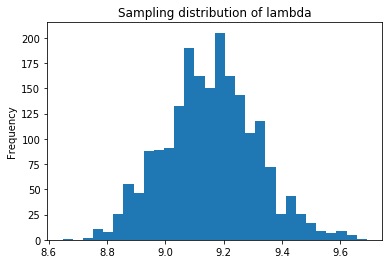

In [59]:
# using very conservative warmup
postWarmup = math.ceil(posteriors.postr.shape[0]*1/5)
posteriors.postr.tail(n=postWarmup)['lambda'].plot(kind='hist',
                                                   bins=30,
                                                   title='Sampling distribution of lambda')

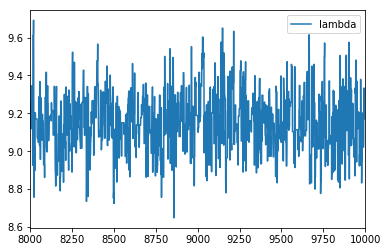

In [62]:
posteriors.postr.tail(n=postWarmup).plot(y='lambda', use_index=True)

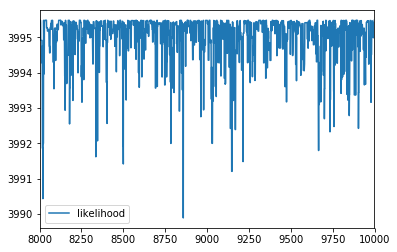

In [63]:
posteriors.postr.tail(n=postWarmup).plot(y='likelihood', use_index=True)